# Code Part

## Download Dataset


In [ ]:
!pip -q install wfdb==3.4.0 
!wget -q https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip
!unzip -qo /content/mit-bih-arrhythmia-database-1.0.0.zip 

## Change the ECG Signal

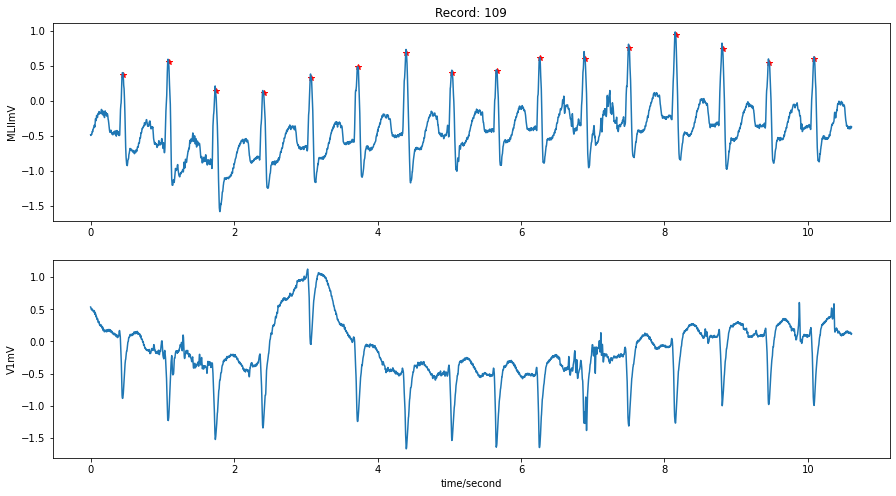

In [ ]:
#@title Choose ECG Signal { form-width: "20%", display-mode: "both" }
signal_number = 9 #@param {type:"slider", min:0, max:9, step:1}
import wfdb
import numpy as np
import pandas as pd
np.set_printoptions(threshold=np.inf) # for printing the whole array

filename = f'/content/mit-bih-arrhythmia-database-1.0.0/{str(100 + signal_number)}'
record = wfdb.rdrecord(filename, sampfrom=180, sampto=4000,)    
annotation = wfdb.rdann(filename, 'atr', sampfrom=180, sampto=4000,shift_samps=True)

wfdb.plot_wfdb(record=record, annotation=annotation, time_units='seconds',figsize=(15,8))
# print(wfdb.rdsamp(filename, sampfrom=100, sampto=4000))

# .xws files are useless?
# .atr contains annotations - not zaroori for assignment
# .hea files contain info? patient details + file names + annotated comments + etc
# .dat file contains signal data

## QRS Detection
(3marks)

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
class Pan_Tompkins_QRS():
  
  def band_pass_filter(self,signal):
    '''
    Band Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    [TODO] 
    This filters the signal to give the output signal with frequencies in a given range.
    For creating the band-pass filter, I first passed the signal through the high pass filter and then passed the signal obtained from that through the low pass filter. 
    This esentially gives me the bandpass fitlered signal --> band_pass =  low_pass(high_pass(signal))
    For implementing the high and low pass filters, I used the difference equations from the reference paper.
    '''
    # create a band pass filter that allows frequencies in the range of 5 - 12 Hz

    # Creating a high-pass filter first-->
    hpf_signal = signal.copy()
	
    for n in signal.index:
      # difference equation of the high-pass filter
      if(i>= 32):
        hpf_signal.iloc[n, 1] = (32*signal.iloc[n - 16, 1] - ( hpf_signal.iloc[n - 1, 1] + signal.iloc[n, 1] - signal.iloc[n - 32, 1]))
        hpf = hpf_signal.copy()

    # now implementing low-pass filter on the signal obtained after passing it through high-pass filter
    lpf_signal = hpf.copy()
    
    for n in hpf.index:
      if(n < 12):
        continue
      # difference equation of the low-pass filter
      lpf_signal.iloc[n, 1] = (2*lpf_signal.iloc[n - 1, 1] - lpf_signal.iloc[n - 2, 1] + hpf.iloc[n, 1] - 2*hpf.iloc[n - 6, 1] + hpf.iloc[n - 12, 1])  
      # this lpf_signal is the band-filtered signal itself since I have passed the same signal through both high and low pass filters now.
      bpf = lpf_signal.copy()
    return bpf
    
  
  def derivative(self,signal):
    '''
    Derivative Filter 
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    [TODO] 
    Here, I used the difference equation for derivative in the paper for obtaining the output signal after getting taking the derivative of the band-pass filtered signal passed in it.
    I used the five-point derivate to prvide QRS-complex slope information 
    '''
    # derivative of the signal --> d_signal
    d_signal = signal.copy()

    for n in signal.index:
      if(n < 4):
        continue
      # difference equation of the derivative
      if(n+2 < len(signal)): d_signal.iloc[n, 1] = (1 / 8) * ( -signal.iloc[n-2,1] - 2 * signal.iloc[n-1, 1] + 2 * signal.iloc[n+1, 1] + signal.iloc[n+2, 1] )
    return d_signal

  def squaring(self,signal):
    '''
    Squaring the Signal
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    [TODO] 
    Here, I pass the derivatve signal to the squaring funciton for performing point by point squaring.
    This makes all data points positive and performs nonlinear amplification of the derivative's output, highlighting the higher frequencies.
    '''
    # squared signal --> sq_signal
    sq_signal = signal.copy()

    for n in signal.index:
      sq_signal.iloc[n,1] = ( signal.iloc[n,1] )**2
    return sq_signal

  def moving_window_integration(self,signal):
    '''
    Moving Window Integrator
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    [TODO] 
    In addition to the slope of the R wave, we also require information about the waveform feature. So, we use moving window integration with the window size of 30.
    using the difference equation in the reference which takes window integrals at each step and returns the overall integral.
    '''
    # Window Size --> w_s
    w_s = 30 

    mwi = signal.copy()
    for i in range(w_s-1,len(signal)): # from 29 -> n integrating for all the points from where we can get the window
        sigma_window = 0
        for j in range(1,w_s+1): # integrating the window
            sigma_window+=signal.iloc[i-(w_s-j),1]
        mwi.iloc[i,1] = sigma_window/w_s

    return mwi

  def solve(self,signal):
    '''
    Solver, Combines all the above functions
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    [TODO] 
    passing the original signal through the bandpass filter to get the bandpass filtered signal. 
    Then passing this filtered signal through a differentiator to obtain a differentiated signal.
    We then square the resultant signal and pass it through the movind window integrator so that we can obtain the waveform feature information.
    '''
    #[TODO]
    # 1. bandpass
    # 2. differentiate
    # 3. square
    # 4. integrate
    bpf_sig = self.band_pass_filter(signal)
    der_sig = self.derivative(bpf_sig)
    sq_sig = self.squaring(der_sig)
    mwi_sig = self.moving_window_integration(sq_sig)
    l = [bpf_sig, der_sig, sq_sig, mwi_sig]
    return mwi_sig


QRS_detector = Pan_Tompkins_QRS()


ecg = pd.DataFrame(np.array([list(range(len(record.adc()))),record.adc()[:,0]]).T,columns=['TimeStamp','ecg'])
output_signal = QRS_detector.solve(ecg)

original = ecg.copy(); #original signal
bp_filtered = QRS_detector.band_pass_filter(original) # bandpass filtered signal
der = QRS_detector.derivative(bp_filtered) # derivative signal
sq = QRS_detector.squaring(der) # squared signal
mwi_sig = QRS_detector.moving_window_integration(sq) # moving window integrated signal

In [ ]:
# implementing delay of 16 for high-pass, 6 for low-pass, 2 for derivative.
delay = 24
delayed_ecg = ecg.copy()
for i in range(len(delayed_ecg)-1, -1, -1):
  if i >= delay:
    delayed_ecg.iloc[i, 1] = ecg.iloc[i-delay, 1]
  else:
    delayed_ecg.iloc[i, 1] = ecg.iloc[delay, 1]

## Plotting the Signals
consider using matlplotlib(or other plotting libraries) to create images for report. Please write code below \\
(1mark)

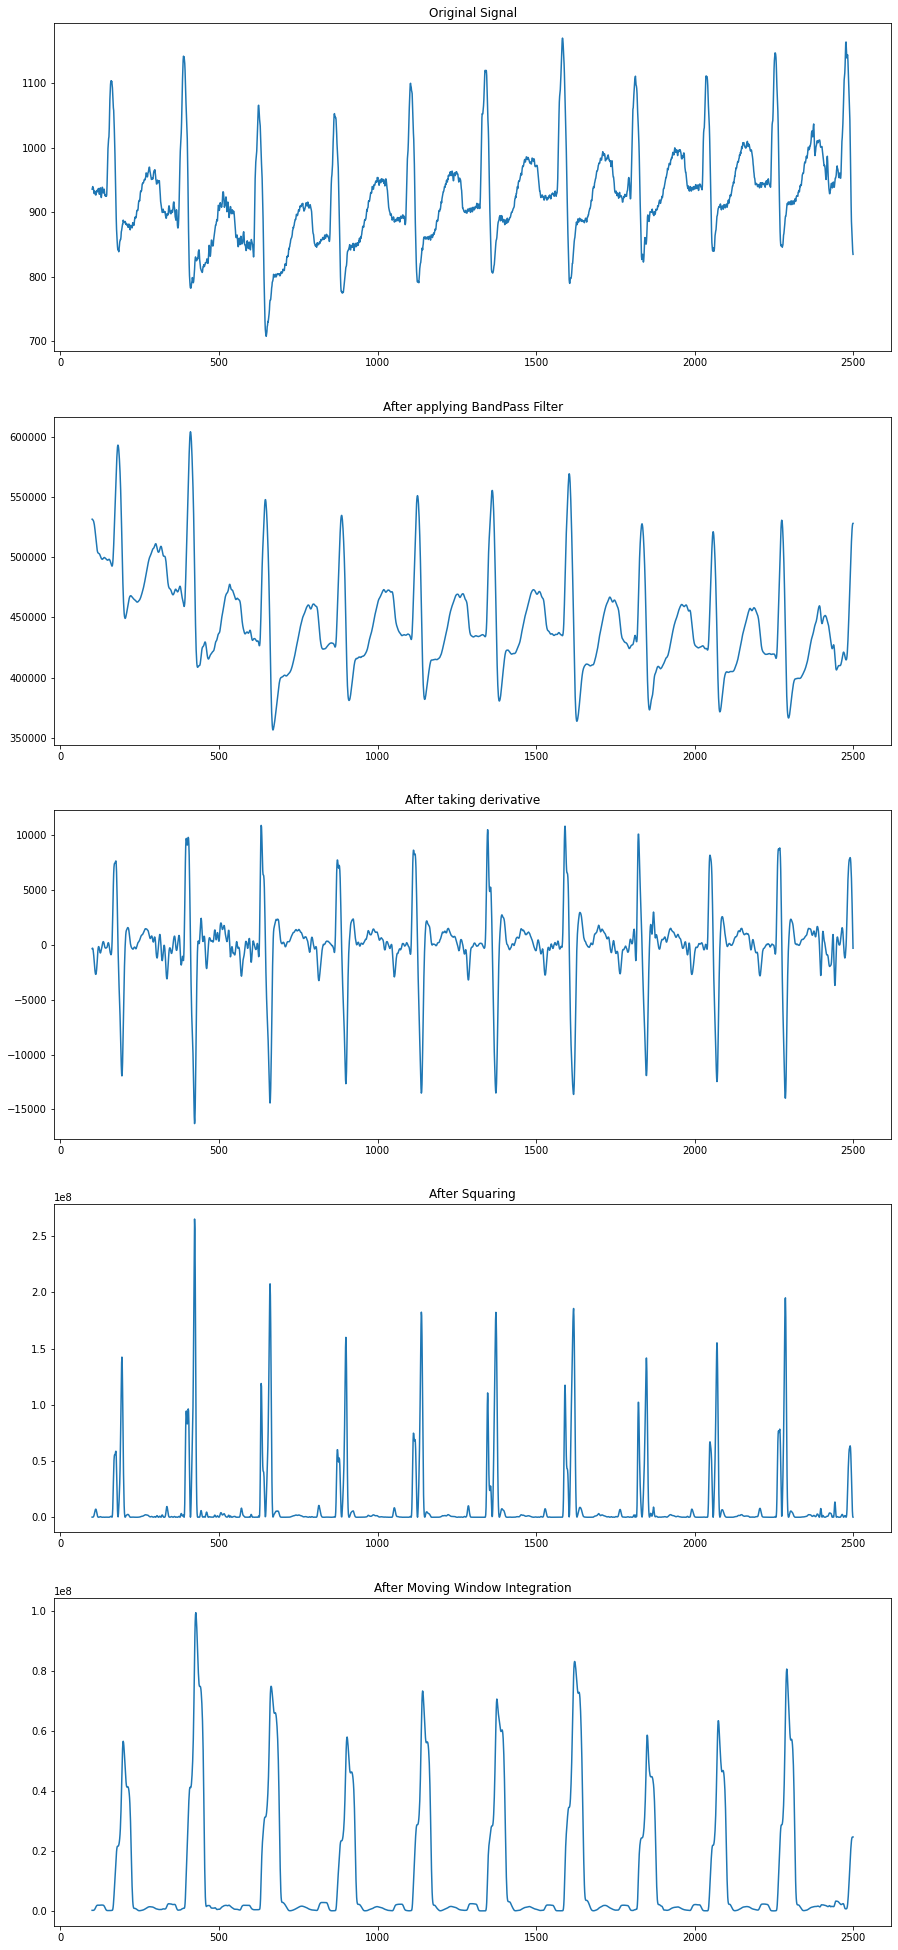

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,35))
plt.subplot(5, 1, 1)
plt.plot(original.iloc[100:2500,0], original.iloc[100:2500,1])
plt.title("Original Signal")

plt.subplot(5, 1, 2)
plt.plot(bp_filtered.iloc[100:2500,0], bp_filtered.iloc[100:2500,1])
plt.title("After applying BandPass Filter")

plt.subplot(5, 1, 3)
plt.plot(der.iloc[100:2500,0], der.iloc[100:2500,1])
plt.title("After taking derivative")

plt.subplot(5, 1, 4)
plt.plot(sq.iloc[100:2500,0], sq.iloc[100:2500,1])
plt.title("After Squaring")

plt.subplot(5, 1, 5)
plt.plot(mwi_sig.iloc[100:2500,0], mwi_sig.iloc[100:2500,1])
plt.title("After Moving Window Integration")
plt.show()

## Calculating Heart Rate
In this section you need to write code to calculate heart rate of the given ecg signal using the help of QRS detected. \\
(1mark)

In [ ]:
class Beat_Detector():
    def search_back(self, isQRS, SPKI, PEAKI, THRESHOLD_I2):
      if(PEAKI > THRESHOLD_I2):
          SPKI = 0.25*PEAKI + 0.75 * SPKI
          isQRS = True

    def Pulse_gen(self,signal,peaks):
        pulse_stream = signal.copy()

        for i in signal.index:
            if(i not in peaks):
                pulse_stream.iloc[i,1] = 0
            else:
                pulse_stream.iloc[i,1] = 1
        return pulse_stream

    def Heartbeat_thresholding(self,signal):
        min_RR = 40
        max_RR = 400
        SPKI = 0 # initializing the Signal and noise peaks to 0
        NPKI = 0
        peaks=[]
        THRESHOLD_I1 = SPKI # initializing the threshold to 0
        THRESHOLD_I2 = SPKI
        searchback = False
        en_searchback = 0
        prev = 0
        i=2
        while i<len(signal)-2:
            if (i-prev > max_RR and i-en_searchback > max_RR):
                en_searchback = i
                searchback = True
                i = prev+2
                continue
            if (searchback == True and i==en_searchback):
                searchback = False
                continue
            PEAKI = signal.iloc[i,1]
            if (PEAKI < signal.iloc[i-1,1] or PEAKI <= signal.iloc[i+1,1]):
                i+=1
                continue
            
            isQRS = False

            if (searchback == True):
                self.search_back(isQRS, SPKI, PEAKI, THRESHOLD_I2)
            elif (THRESHOLD_I1 < PEAKI):
                SPKI = 0.875*SPKI + 0.125*PEAKI
                isQRS = True

            if isQRS == False:
                NPKI = 0.125*PEAKI + 0.875*NPKI
            else:
                if (prev == 0 or i - prev >= min_RR):
                    peaks.append(i)
                elif (signal.iloc[prev,1] < PEAKI):
                    peaks[-1] = i
                prev = i
            
            THRESHOLD_I1 = 0.25*SPKI + 0.75*NPKI # from the reference equations to compute thresholds
            THRESHOLD_I2 = 0.5*THRESHOLD_I1
            i+=1
        return peaks

    def solve(self,signal):
        f1 = self.Heartbeat_thresholding(signal)
        pulse = self.Pulse_gen(signal,f1)
        return f1,pulse

detector = Beat_Detector()
Peak_Id, pulse = detector.solve(output_signal)
peak_values = []
for i in Peak_Id:
  peak_values.append(mwi_sig.iloc[i, 1])
print(Peak_Id)


[3, 59, 198, 427, 664, 904, 1142, 1376, 1621, 1850, 2074, 2290, 2516, 2739, 2972, 3207, 3442, 3668]


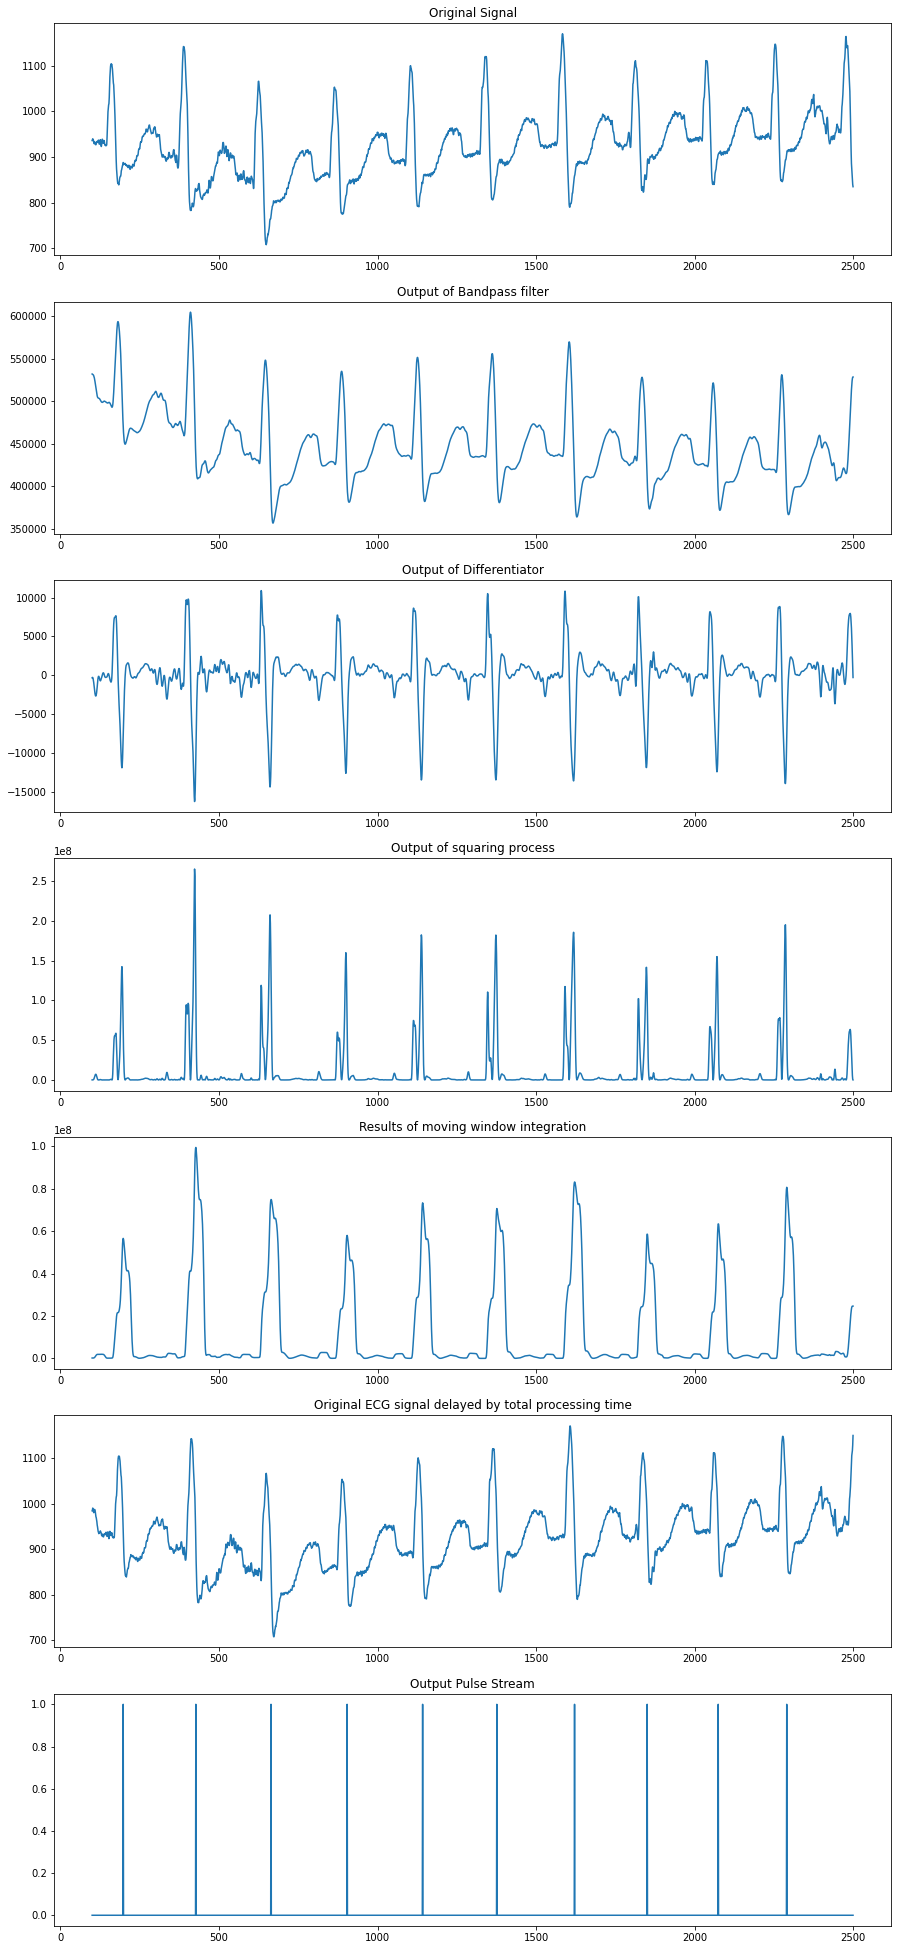

In [ ]:
plt.figure(figsize=(15,35)) 
plt.subplot(7,1,1)
plt.plot(ecg.iloc[100:2500,0], ecg.iloc[100:2500,1])
plt.title("Original Signal")

plt.subplot(7,1,2)
plt.plot(bp_filtered.iloc[100:2500,0], bp_filtered.iloc[100:2500,1])
plt.title("Output of Bandpass filter")

plt.subplot(7,1,3)
plt.plot(der.iloc[100:2500,0], der.iloc[100:2500,1])
plt.title("Output of Differentiator")

plt.subplot(7,1,4)
plt.plot(sq.iloc[100:2500,0], sq.iloc[100:2500,1])
plt.title("Output of squaring process")

plt.subplot(7,1,5)
plt.plot(mwi_sig.iloc[100:2500,0], mwi_sig.iloc[100:2500,1])
# plt.scatter(Peak_Id, peak_values, marker ="x", c="r")
plt.title("Results of moving window integration")

plt.subplot(7,1,6)
plt.plot(delayed_ecg.iloc[100:2500,0], delayed_ecg.iloc[100:2500,1])
plt.title("Original ECG signal delayed by total processing time")

plt.subplot(7,1,7)
plt.plot(pulse.iloc[100:2500,0], pulse.iloc[100:2500,1])
plt.title("Output Pulse Stream")

plt.savefig("QRS detection steps for signal " + str(signal_number),bbox_inches='tight')
# plt.show()

In [ ]:
difference=[]
for n in range(len(Peak_Id)-1):
  difference.append(Peak_Id[n+1]- Peak_Id[n])
avg_RR=abs(np.mean(difference))

beats_per_min = (60 * 360 / (avg_RR)) 
print(beats_per_min)

100.19099590723056
